<a href="https://colab.research.google.com/github/yasinsoylu1997/TEZZ2/blob/main/vgg19_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import keras
import keras.utils
from keras import utils as np_utils
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#!pip install visualkeras
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
!pip install visualkeras
!pip install catboost

     |████████████████████████████████| 992 kB 5.1 MB/s 
     |████████████████████████████████| 76.6 MB 50 kB/s 


In [3]:
labels = ['Lung_Opacity','COVID','Normal','Viral Pneumonia']

In [4]:
X = []
y = []
image_size = 32
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/tezz3/COVID-19_Radiography_Dataset_masked',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

        
X = np.array(X)
y = np.array(y)

100%|██████████| 1345/1345 [00:24<00:00, 54.88it/s] 


In [5]:
from imblearn.over_sampling import RandomOverSampler
reshaped_X = X.reshape(X.shape[0],-1)

#oversampling
oversample = RandomOverSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

# reshaping X back to the first dims
new_X = oversampled_X.reshape(-1,32,32,3)
oversampled_y

array(['Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', ...,
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia'],
      dtype='<U15')

In [6]:
train_images, test_images,train_labels, test_labels = train_test_split(new_X , oversampled_y , test_size=0.25, random_state=42,shuffle=True)

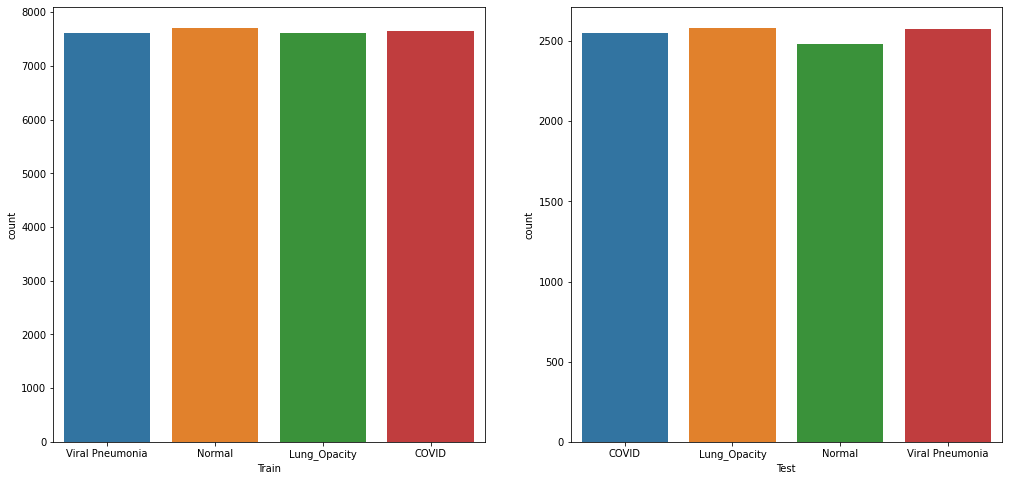

In [7]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [8]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [10]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [11]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [12]:
y_test_one_hot

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [13]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [14]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_model= features #This is our X input to RF

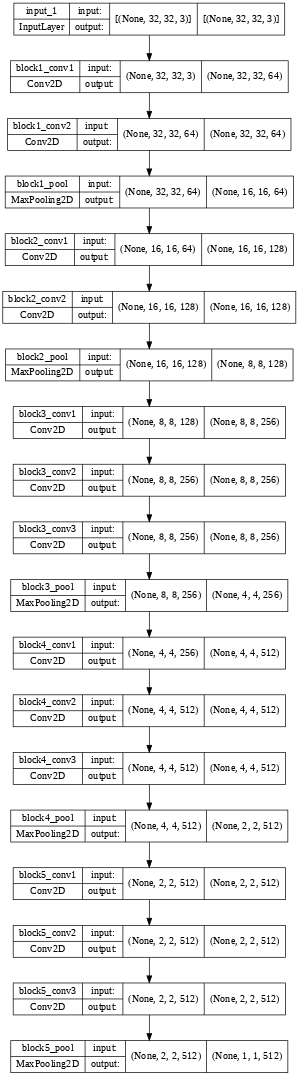

In [15]:
from keras.utils.vis_utils import plot_model

plot_model(VGG_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=50)

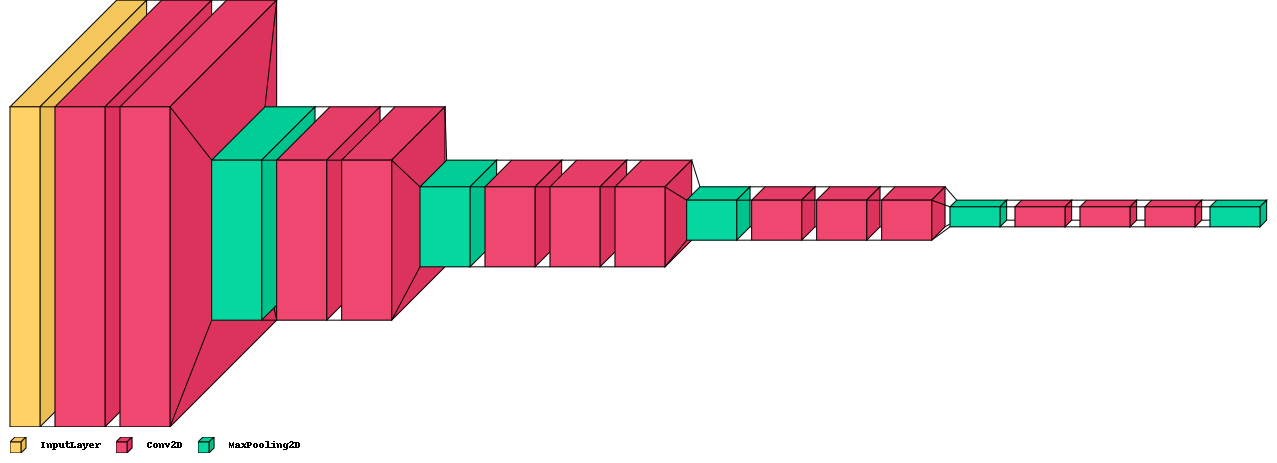

<Figure size 144x144 with 0 Axes>

In [16]:
import visualkeras
from PIL import ImageFont
plt.figure(figsize=(2, 2))
visualkeras.layered_view(VGG_model, legend=True,spacing=15,scale_xy = 10 , scale_z = 10, max_z = 50) 

In [17]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X_for_model, y_train)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('Accuracy', Accuracy)



    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    return mae, mse, rmse, r2_square, Accuracy

# knn

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_for_model, y_train)
knn_model

KNeighborsClassifier()

In [19]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = knn_model.predict(X_test_features)

In [20]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.28767660910518056
MSE: 0.42778649921507067
RMSE: 0.6540538962616694
R2 Square 0.6594812006995923
Accuracy 0.7808084772370487
__________________________________


In [21]:
results_df = pd.DataFrame(data=[["KNeighborsClassifier", *evaluate(y_test, prediction) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy'])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.287677,0.427786,0.654054,0.659481,0.780808


In [22]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.69      0.79      0.74      2550
           1       0.74      0.65      0.69      2583
           2       0.73      0.69      0.71      2481
           3       0.95      0.99      0.97      2578

    accuracy                           0.78     10192
   macro avg       0.78      0.78      0.78     10192
weighted avg       0.78      0.78      0.78     10192



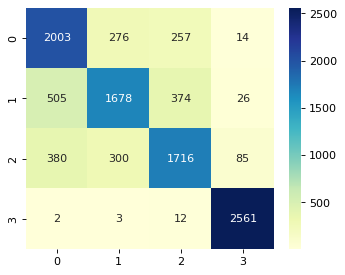

In [23]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SVC

In [24]:
from sklearn.svm import SVC
svm_model = SVC(kernel = "linear")
svm_model = svm_model.fit(X_for_model, y_train)
svm_model

SVC(kernel='linear')

In [25]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = svm_model.predict(X_test_features)

In [26]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.3025902668759812
MSE: 0.4664442700156986
RMSE: 0.6829672539849173
R2 Square 0.6287095477352893
Accuracy 0.7769819466248038
__________________________________


In [27]:
results_df_2 = pd.DataFrame(data=[["SVC", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.287677,0.427786,0.654054,0.659481,0.780808
1,SVC,0.302590,0.466444,0.682967,0.628710,0.776982


In [28]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.68      0.65      0.67      2550
           1       0.73      0.72      0.73      2583
           2       0.72      0.75      0.74      2481
           3       0.96      0.98      0.97      2578

    accuracy                           0.78     10192
   macro avg       0.77      0.78      0.78     10192
weighted avg       0.78      0.78      0.78     10192



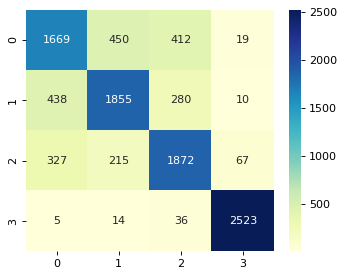

In [29]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RBF SVC

In [30]:
from sklearn.svm import SVC

svc_model = SVC(kernel = "rbf").fit(X_for_model, y_train)
svc_model = svc_model.fit(X_for_model, y_train)
svc_model

SVC()

In [31]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = svc_model.predict(X_test_features)

In [32]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.361361852433281
MSE: 0.5711342229199372
RMSE: 0.7557342277017346
R2 Square 0.5453761626771392
Accuracy 0.73675431711146
__________________________________


In [33]:
results_df_2 = pd.DataFrame(data=[["RBF SVC", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.287677,0.427786,0.654054,0.659481,0.780808
1,SVC,0.302590,0.466444,0.682967,0.628710,0.776982
2,RBF SVC,0.361362,0.571134,0.755734,0.545376,0.736754


In [34]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.64      0.60      0.62      2550
           1       0.69      0.67      0.68      2583
           2       0.67      0.72      0.70      2481
           3       0.93      0.95      0.94      2578

    accuracy                           0.74     10192
   macro avg       0.73      0.74      0.73     10192
weighted avg       0.73      0.74      0.74     10192



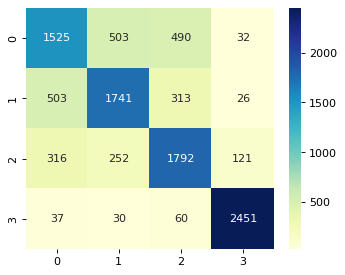

In [35]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# DecisionTreeClassifier

In [36]:
from sklearn.tree import DecisionTreeClassifier
cart_model = DecisionTreeClassifier()
cart_model = cart_model.fit(X_for_model, y_train)
cart_model

DecisionTreeClassifier()

In [37]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = cart_model.predict(X_test_features)

In [38]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.18485086342229198
MSE: 0.26550235478806905
RMSE: 0.5152692061321625
R2 Square 0.7886596626360314
Accuracy 0.8550824175824175
__________________________________


In [39]:
results_df_2 = pd.DataFrame(data=[["DecisionTreeClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.287677,0.427786,0.654054,0.659481,0.780808
1,SVC,0.302590,0.466444,0.682967,0.628710,0.776982
2,RBF SVC,0.361362,0.571134,0.755734,0.545376,0.736754
3,DecisionTreeClassifier,0.184851,0.265502,0.515269,0.788660,0.855082


In [40]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2550
           1       0.80      0.81      0.80      2583
           2       0.82      0.68      0.74      2481
           3       0.97      1.00      0.99      2578

    accuracy                           0.86     10192
   macro avg       0.85      0.85      0.85     10192
weighted avg       0.85      0.86      0.85     10192



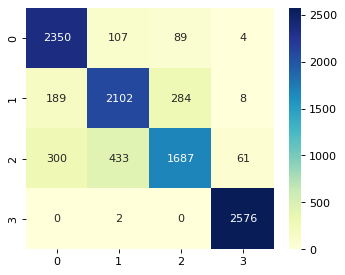

In [41]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# Lojistik regresyon

In [42]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_for_model, y_train)
lr_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [43]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = lr_model.predict(X_test_features)

In [44]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.3676412872841444
MSE: 0.5760400313971743
RMSE: 0.7589730109807425
R2 Square 0.5414711305750702
Accuracy 0.729886185243328
__________________________________


In [45]:
results_df_2 = pd.DataFrame(data=[["LogisticRegression", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.287677,0.427786,0.654054,0.659481,0.780808
1,SVC,0.302590,0.466444,0.682967,0.628710,0.776982
2,RBF SVC,0.361362,0.571134,0.755734,0.545376,0.736754
3,DecisionTreeClassifier,0.184851,0.265502,0.515269,0.788660,0.855082
4,LogisticRegression,0.367641,0.576040,0.758973,0.541471,0.729886


In [46]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.65      0.56      0.61      2550
           1       0.67      0.70      0.68      2583
           2       0.67      0.71      0.69      2481
           3       0.92      0.95      0.93      2578

    accuracy                           0.73     10192
   macro avg       0.73      0.73      0.73     10192
weighted avg       0.73      0.73      0.73     10192



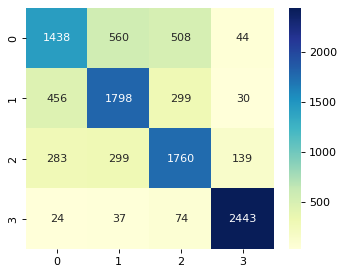

In [47]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SGDClassifier

In [48]:
from sklearn.linear_model import SGDClassifier

SGD_model = SGDClassifier()
SGD_model = SGD_model.fit(X_for_model, y_train)
SGD_model

SGDClassifier()

In [49]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = SGD_model.predict(X_test_features)

In [50]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.4366169544740973
MSE: 0.7547095761381476
RMSE: 0.8687402236216231
R2 Square 0.3992498614177211
Accuracy 0.7061420722135008
__________________________________


In [51]:
results_df_2 = pd.DataFrame(data=[["SGDClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.287677,0.427786,0.654054,0.659481,0.780808
1,SVC,0.302590,0.466444,0.682967,0.628710,0.776982
2,RBF SVC,0.361362,0.571134,0.755734,0.545376,0.736754
3,DecisionTreeClassifier,0.184851,0.265502,0.515269,0.788660,0.855082
4,LogisticRegression,0.367641,0.576040,0.758973,0.541471,0.729886
5,SGDClassifier,0.436617,0.754710,0.868740,0.399250,0.706142


In [52]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.49      0.87      0.63      2550
           1       0.84      0.46      0.59      2583
           2       0.77      0.58      0.66      2481
           3       0.96      0.92      0.94      2578

    accuracy                           0.71     10192
   macro avg       0.77      0.71      0.71     10192
weighted avg       0.77      0.71      0.71     10192



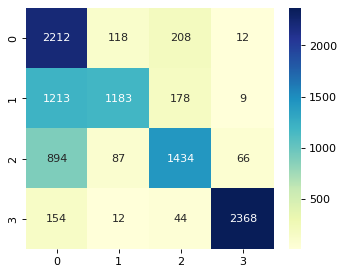

In [53]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GradientBoostingClassifier

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

GBC_model = GradientBoostingClassifier()
GBC_model = GBC_model.fit(X_for_model, y_train)
GBC_model

GradientBoostingClassifier()

In [55]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = GBC_model.predict(X_test_features)

In [56]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.3131868131868132
MSE: 0.4899921507064364
RMSE: 0.699994393339287
R2 Square 0.6099653936453586
Accuracy 0.7710949764521193
__________________________________


In [57]:
results_df_2 = pd.DataFrame(data=[["GradientBoostingClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.287677,0.427786,0.654054,0.659481,0.780808
1,SVC,0.302590,0.466444,0.682967,0.628710,0.776982
2,RBF SVC,0.361362,0.571134,0.755734,0.545376,0.736754
3,DecisionTreeClassifier,0.184851,0.265502,0.515269,0.788660,0.855082
4,LogisticRegression,0.367641,0.576040,0.758973,0.541471,0.729886
5,SGDClassifier,0.436617,0.754710,0.868740,0.399250,0.706142
6,GradientBoostingClassifier,0.313187,0.489992,0.699994,0.609965,0.771095


In [58]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.70      0.67      0.68      2550
           1       0.73      0.70      0.72      2583
           2       0.70      0.73      0.71      2481
           3       0.94      0.98      0.96      2578

    accuracy                           0.77     10192
   macro avg       0.77      0.77      0.77     10192
weighted avg       0.77      0.77      0.77     10192



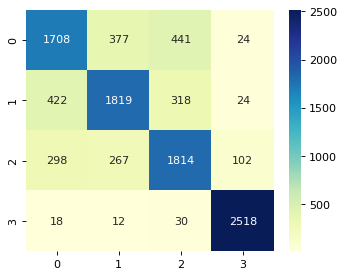

In [59]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# LGBMClassifier

In [60]:
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model = LGBM_model.fit(X_for_model, y_train)
LGBM_model

LGBMClassifier()

In [61]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = LGBM_model.predict(X_test_features)

In [62]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.19858712715855573
MSE: 0.29277864992150704
RMSE: 0.541090241938909
R2 Square 0.7669476841485283
Accuracy 0.8483124018838305
__________________________________


In [63]:
results_df_2 = pd.DataFrame(data=[["LGBMClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.287677,0.427786,0.654054,0.659481,0.780808
1,SVC,0.302590,0.466444,0.682967,0.628710,0.776982
2,RBF SVC,0.361362,0.571134,0.755734,0.545376,0.736754
3,DecisionTreeClassifier,0.184851,0.265502,0.515269,0.788660,0.855082
4,LogisticRegression,0.367641,0.576040,0.758973,0.541471,0.729886
5,SGDClassifier,0.436617,0.754710,0.868740,0.399250,0.706142
6,GradientBoostingClassifier,0.313187,0.489992,0.699994,0.609965,0.771095
7,LGBMClassifier,0.198587,0.292779,0.541090,0.766948,0.848312


In [64]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      2550
           1       0.82      0.79      0.80      2583
           2       0.79      0.78      0.79      2481
           3       0.97      1.00      0.98      2578

    accuracy                           0.85     10192
   macro avg       0.85      0.85      0.85     10192
weighted avg       0.85      0.85      0.85     10192



# XGBClassifier

In [65]:
from xgboost.sklearn import XGBClassifier

XGBC_model = XGBClassifier()
XGBC_model = XGBC_model.fit(X_for_model, y_train)
XGBC_model

XGBClassifier(objective='multi:softprob')

In [66]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = XGBC_model.predict(X_test_features)

In [67]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.3410518053375196
MSE: 0.5374803767660911
RMSE: 0.7331305318741616
R2 Square 0.5721646828973317
Accuracy 0.7521585557299842
__________________________________


In [68]:
results_df_2 = pd.DataFrame(data=[["XGBClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.287677,0.427786,0.654054,0.659481,0.780808
1,SVC,0.302590,0.466444,0.682967,0.628710,0.776982
2,RBF SVC,0.361362,0.571134,0.755734,0.545376,0.736754
3,DecisionTreeClassifier,0.184851,0.265502,0.515269,0.788660,0.855082
4,LogisticRegression,0.367641,0.576040,0.758973,0.541471,0.729886
5,SGDClassifier,0.436617,0.754710,0.868740,0.399250,0.706142
6,GradientBoostingClassifier,0.313187,0.489992,0.699994,0.609965,0.771095
7,LGBMClassifier,0.198587,0.292779,0.541090,0.766948,0.848312
8,XGBClassifier,0.341052,0.537480,0.733131,0.572165,0.752159


In [69]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.68      0.63      0.65      2550
           1       0.71      0.69      0.70      2583
           2       0.67      0.72      0.69      2481
           3       0.94      0.97      0.95      2578

    accuracy                           0.75     10192
   macro avg       0.75      0.75      0.75     10192
weighted avg       0.75      0.75      0.75     10192



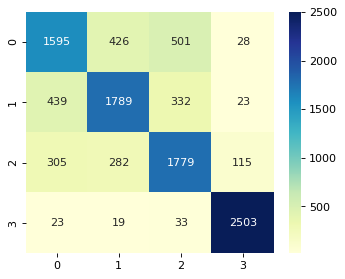

In [70]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RandomForestClassifier

In [71]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_for_model, y_train)
rf_model

RandomForestClassifier()

In [72]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = rf_model.predict(X_test_features)

In [73]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.11175431711145997
MSE: 0.15414050235478807
RMSE: 0.39260731317028225
R2 Square 0.8773038913529952
Accuracy 0.9092425431711146
__________________________________


In [74]:
results_df_2 = pd.DataFrame(data=[["RandomForestClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.287677,0.427786,0.654054,0.659481,0.780808
1,SVC,0.302590,0.466444,0.682967,0.628710,0.776982
2,RBF SVC,0.361362,0.571134,0.755734,0.545376,0.736754
3,DecisionTreeClassifier,0.184851,0.265502,0.515269,0.788660,0.855082
4,LogisticRegression,0.367641,0.576040,0.758973,0.541471,0.729886
5,SGDClassifier,0.436617,0.754710,0.868740,0.399250,0.706142
6,GradientBoostingClassifier,0.313187,0.489992,0.699994,0.609965,0.771095
7,LGBMClassifier,0.198587,0.292779,0.541090,0.766948,0.848312
8,XGBClassifier,0.341052,0.537480,0.733131,0.572165,0.752159
9,RandomForestClassifier,0.111754,0.154141,0.392607,0.877304,0.909243


In [75]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2550
           1       0.86      0.88      0.87      2583
           2       0.87      0.82      0.85      2481
           3       0.98      1.00      0.99      2578

    accuracy                           0.91     10192
   macro avg       0.91      0.91      0.91     10192
weighted avg       0.91      0.91      0.91     10192



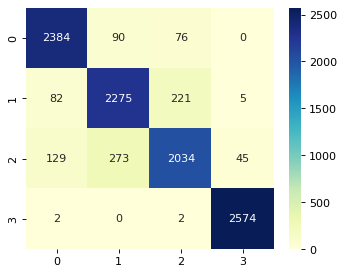

In [76]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GaussianNB

In [77]:
from sklearn.naive_bayes import GaussianNB


GB_model = GaussianNB()
GB_model = GB_model.fit(X_for_model, y_train)
GB_model

GaussianNB()

In [78]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = GB_model.predict(X_test_features)

In [79]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.5966444270015698
MSE: 0.8817700156985872
RMSE: 0.9390260995832795
R2 Square 0.29810952997413664
Accuracy 0.5188383045525903
__________________________________


In [80]:
results_df_2 = pd.DataFrame(data=[["GaussianNB", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.287677,0.427786,0.654054,0.659481,0.780808
1,SVC,0.302590,0.466444,0.682967,0.628710,0.776982
2,RBF SVC,0.361362,0.571134,0.755734,0.545376,0.736754
3,DecisionTreeClassifier,0.184851,0.265502,0.515269,0.788660,0.855082
4,LogisticRegression,0.367641,0.576040,0.758973,0.541471,0.729886
5,SGDClassifier,0.436617,0.754710,0.868740,0.399250,0.706142
6,GradientBoostingClassifier,0.313187,0.489992,0.699994,0.609965,0.771095
7,LGBMClassifier,0.198587,0.292779,0.541090,0.766948,0.848312
8,XGBClassifier,0.341052,0.537480,0.733131,0.572165,0.752159
9,RandomForestClassifier,0.111754,0.154141,0.392607,0.877304,0.909243


In [81]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.72      0.10      0.17      2550
           1       0.38      0.90      0.54      2583
           2       0.64      0.17      0.27      2481
           3       0.74      0.89      0.81      2578

    accuracy                           0.52     10192
   macro avg       0.62      0.51      0.45     10192
weighted avg       0.62      0.52      0.45     10192



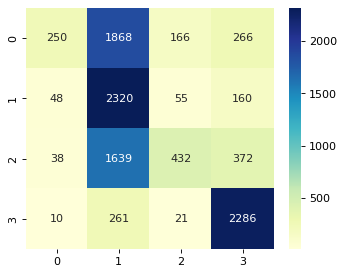

In [82]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [83]:
modeller = [rf_model,GB_model,XGBC_model,LGBM_model,GBC_model,SGD_model,lr_model,cart_model,svc_model,svm_model,knn_model]

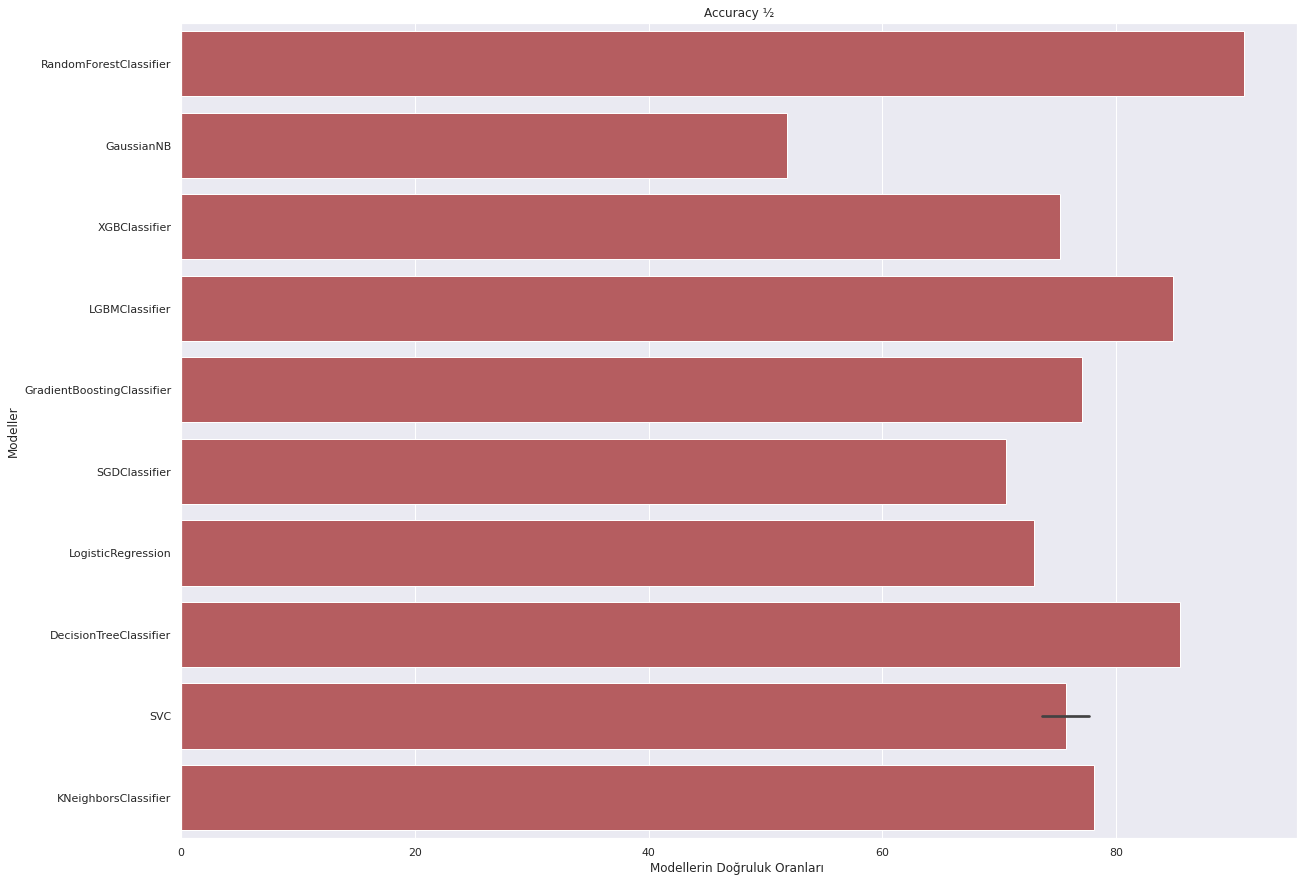

In [84]:
sonuc = []
from sklearn.metrics import accuracy_score

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test_features)
    dogruluk = accuracy_score(y_test, y_pred)    
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy"])
    sonuclar = sonuclar.append(sonuc)
    
sns.set(rc={'figure.figsize':(20,15)})
sns.barplot(x= 'Accuracy', y = 'Modeller', data=sonuclar, color="r")
plt.xlabel('Modellerin Doğruluk Oranları ')
plt.title('Accuracy ½'); 

In [85]:
results_df


,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.287677,0.427786,0.654054,0.659481,0.780808
1,SVC,0.302590,0.466444,0.682967,0.628710,0.776982
2,RBF SVC,0.361362,0.571134,0.755734,0.545376,0.736754
3,DecisionTreeClassifier,0.184851,0.265502,0.515269,0.788660,0.855082
4,LogisticRegression,0.367641,0.576040,0.758973,0.541471,0.729886
5,SGDClassifier,0.436617,0.754710,0.868740,0.399250,0.706142
6,GradientBoostingClassifier,0.313187,0.489992,0.699994,0.609965,0.771095
7,LGBMClassifier,0.198587,0.292779,0.541090,0.766948,0.848312
8,XGBClassifier,0.341052,0.537480,0.733131,0.572165,0.752159
9,RandomForestClassifier,0.111754,0.154141,0.392607,0.877304,0.909243


In [86]:
from google.colab import files

results_df.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>